<a href="https://colab.research.google.com/github/GeorgeTsio/MachineLearning_PyTorch_ToyProblems/blob/main/Breast_cancer_ultrasound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0.0 Defining some libraries

In [19]:
import zipfile
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision


from google.colab import files
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision import models
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from timeit import default_timer as timer

device = "cuda" if torch.cuda.is_available() else "cpu"

### 0.1 Defining some global variables

In [47]:
BATCH_SIZE = 16
EPOCHS = 15
NUM_WORKERS = os.cpu_count()

### 0.2 Defining some helper functions

In [21]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [22]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [23]:
# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": [] }

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epoch
  return results

In [24]:
def plot_loss_curves( results: dict[str, list[float]]):
  """ Plots training curves of a results dictionary."""

  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

### 1. Get the data from kaggle

In [25]:
# Upload kaggle.json from your profile in kaggle
files.upload()

# Install kaggle API client
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle, so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy and paste the API command of your data
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Saving kaggle.json to kaggle.json
100% 195M/195M [00:01<00:00, 189MB/s]
100% 195M/195M [00:01<00:00, 117MB/s]


In [26]:
data_path = Path("breast-ultrasound-images-data")

# Unzip the data
with zipfile.ZipFile("breast-ultrasound-images-dataset.zip") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall(data_path)
  print("Done!")

Unzipping data...
Done!


## 2. Data exploration

In [27]:
# Walk through a path and return its contents.
for dirpath, dirnames, filenames in os.walk(data_path / "Dataset_BUSI_with_GT"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 0 images in 'breast-ultrasound-images-data/Dataset_BUSI_with_GT'
There are 0 directories and 266 images in 'breast-ultrasound-images-data/Dataset_BUSI_with_GT/normal'
There are 0 directories and 421 images in 'breast-ultrasound-images-data/Dataset_BUSI_with_GT/malignant'
There are 0 directories and 891 images in 'breast-ultrasound-images-data/Dataset_BUSI_with_GT/benign'


In [28]:
# Get all the image paths
image_path_list_1 = list(data_path.glob("**/*.png"))

image_path_list_2 = [str(path) for path in image_path_list_1 if '_mask' not in str(path)]
print(f"Number of images: {len(image_path_list_2)}")

# Store the label of each image
labels = [os.path.split(os.path.split(name)[0])[1] for name in image_path_list_2]
print(f"Number of labels: {len(labels)}")

# Extract the classes
classes = list(set(labels))
labels_dict = {label : i for i, label in enumerate(classes)}
labels_val = [labels_dict[label_key] for label_key in labels]

print(f"Number of different classes: {len(classes)}")
print(f"Classes names: {classes}")

# Let's check the size of a random image
img = Image.open(image_path_list_2[50])
print("Random image size: ", img.size)
#print(f"The size of a random image is: {random_img.height}")

Number of images: 780
Number of labels: 780
Number of different classes: 3
Classes names: ['malignant', 'benign', 'normal']
Random image size:  (545, 463)


### 2.1 Display some random images


Randomly sampled images from the data: 


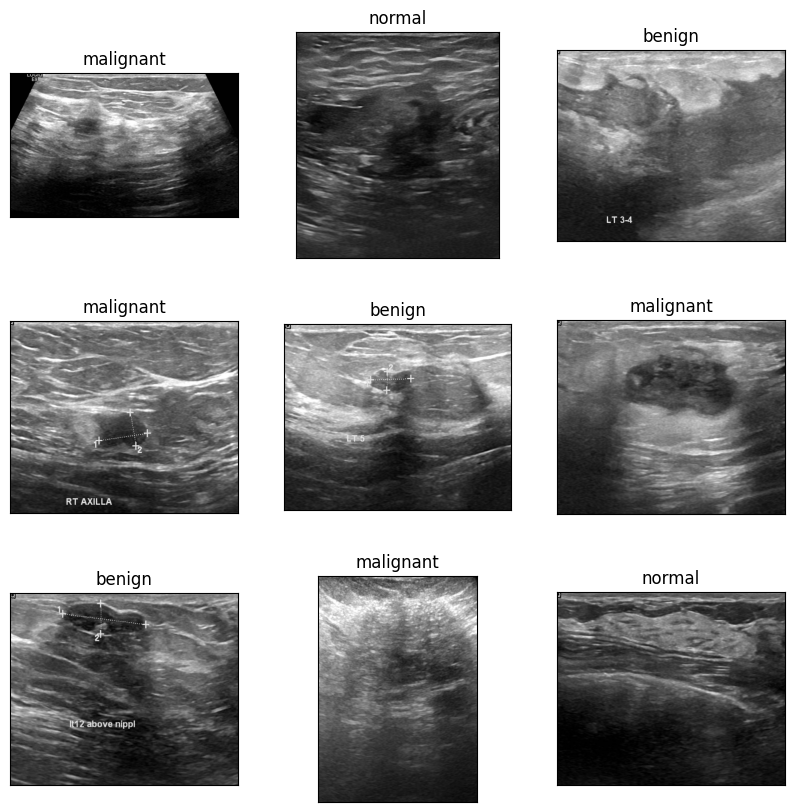

In [29]:
# Display 9 random images of the dataset with their labels
random_index = random.sample(range(len(image_path_list_2)), k=9)
fig, axes = plt.subplots(3,3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

print('Randomly sampled images from the data: ')

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_path_list_2[random_index[i]]))
    ax.set_title(labels[random_index[i]])
plt.show()

## 3. Create a custom Dataset to replicate ImageFolder

In [30]:
class ImageFolderCustom(Dataset):
  def __init__(self, images: list, labels: list, transform=None):
    super().__init__()
    self.images = images
    self.labels = labels
    self.transform = transform


  def __len__(self, ):
    """ Returns the total number of samples. """
    return len(self.labels)

  def __getitem__(self, index):
    """Returns the transformed image and its label. """

    image = Image.open(self.images[index])

    image = self.transform(image)

    label = self.labels[index]

    return image, label

## 4. Create a basic transformation for our data

In [31]:
data_transform_basic = transforms.Compose([
                                           # Resize our images to 128x128
                                           transforms.Resize(size=(128,128)),
                                           # Turn the image into a torch.Tensor
                                           transforms.ToTensor() ])

## 5. Split to train and test set

In [32]:
#data, test_data, labels, test_labels = train_test_split(image_path_list_2, labels_val, test_size=0.15, shuffle=True)
#train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.1, shuffle=True)
#print(f"The length of train data: {len(train_data)} with {len(train_labels)} labels")
#print(f"The length of test data: {len(test_data)} with {len(test_labels)} labels")
#print(f"The length of validation data: {len(val_data)} with {len(val_labels)} labels")

In [33]:
train_paths, test_paths, train_labels, test_labels = train_test_split( image_path_list_2, labels_val, test_size=0.2, random_state=42)
print(f"The length of train data: {len(train_paths)} with {len(train_labels)} labels")
print(f"The length of test data: {len(test_paths)} with {len(test_labels)} labels")

The length of train data: 624 with 624 labels
The length of test data: 156 with 156 labels


## 6. Create datasets and then DataLoaders

In [34]:
train_dataset = ImageFolderCustom(images = train_paths,
                                   labels = train_labels,
                                   transform = data_transform_basic)

test_dataset = ImageFolderCustom(images = test_paths,
                                 labels = test_labels,
                                 transform = data_transform_basic)

#val_dataset = ImageFolderCustom(images = val_data,
#                                labels = val_labels,
#                                transform = data_transform_basic)

In [35]:
# Tranasform the dataset to DataLoaders
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers= NUM_WORKERS,
                              shuffle = True)

test_dataloader =  DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers= NUM_WORKERS,
                              shuffle = False)

## Model 0: A simple model

In [36]:
#initializing a simple ResNet-50 model;
class ResNet34Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.pool1 = nn.AvgPool2d(2)
        self.network.fc = nn.Linear(self.network.fc.in_features, len(classes))

    def forward(self, x):
        return self.network(x)

In [39]:
model_3 = ResNet34Model()
model_3.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet34Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [48]:
start_time = timer()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(),
                             lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.6070 | Train acc: 0.7804 | Test loss: 0.6896 | Test acc: 0.7676
Epoch: 1 | Train loss: 0.4216 | Train acc: 0.8429 | Test loss: 0.7957 | Test acc: 0.7484
Epoch: 2 | Train loss: 0.3409 | Train acc: 0.8846 | Test loss: 0.2940 | Test acc: 0.9087
Epoch: 3 | Train loss: 0.2630 | Train acc: 0.9119 | Test loss: 0.6081 | Test acc: 0.7724
Epoch: 4 | Train loss: 0.3369 | Train acc: 0.8766 | Test loss: 0.4612 | Test acc: 0.8365
Epoch: 5 | Train loss: 0.2531 | Train acc: 0.9119 | Test loss: 0.1004 | Test acc: 0.9663
Epoch: 6 | Train loss: 0.1893 | Train acc: 0.9391 | Test loss: 0.6028 | Test acc: 0.8269
Epoch: 7 | Train loss: 0.2256 | Train acc: 0.9183 | Test loss: 0.1541 | Test acc: 0.9519
Epoch: 8 | Train loss: 0.1690 | Train acc: 0.9375 | Test loss: 0.1636 | Test acc: 0.9407
Epoch: 9 | Train loss: 0.0788 | Train acc: 0.9856 | Test loss: 0.0313 | Test acc: 0.9904
Epoch: 10 | Train loss: 0.0385 | Train acc: 0.9872 | Test loss: 0.0977 | Test acc: 0.9663
Epoch: 11 | Train lo

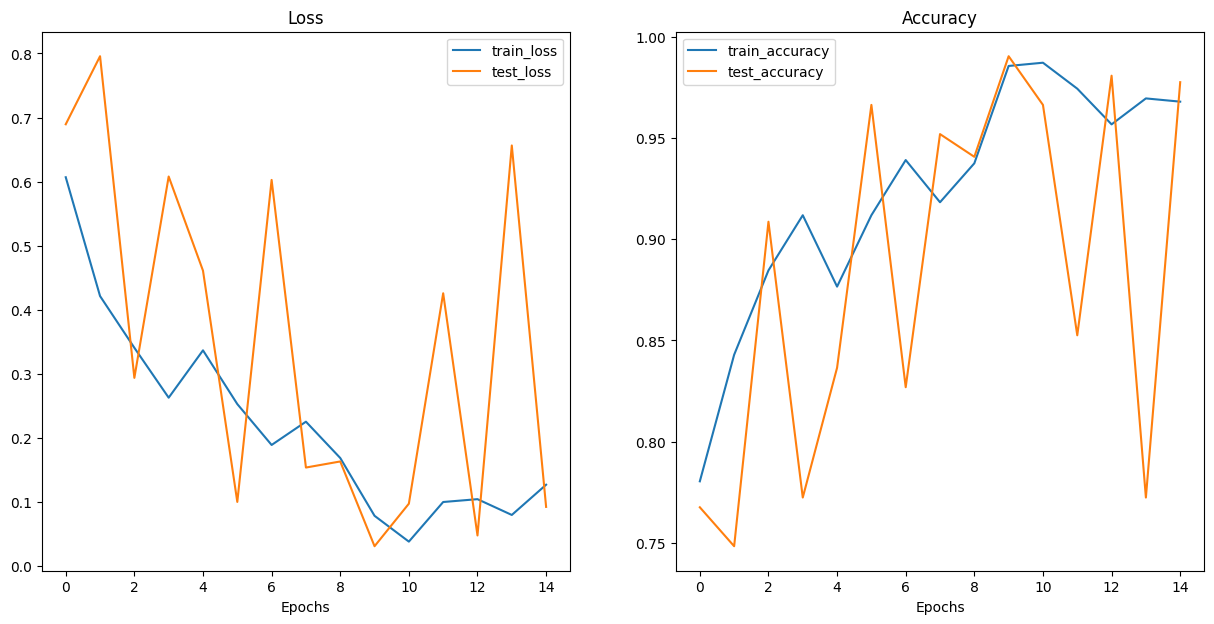

In [49]:
 # Print out the loss curves for our model
plot_loss_curves(model_3_results)

### 8. Let's make a prediction on two different images I found on Internet (1 normal and 1 malignant)

We have to make sure our custom image is in the same format as the data our model was trained on. That means we have to fix:

* Tensor form with datatype(torch.float32)
* Shape 64x64x3
* The right device
* Add the batch size dimension

In [51]:
custom_transform = transforms.Compose([
                                      transforms.Resize(size=(124, 124)) ])

In [52]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        transform=None,
                        device=device):
  """ Makes a prediction on a target image with a trained model and plots the image and prediction"""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediciton probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probabily
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape for matplotlib
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title);
  plt.axis(False)

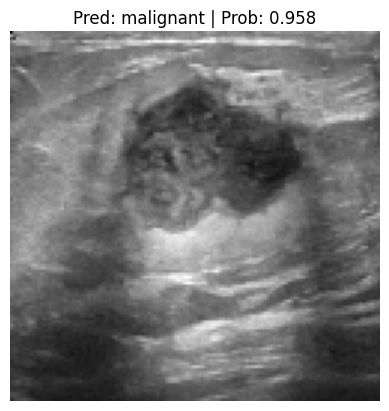

In [53]:
# Make a prediction for a malignant image
pred_and_plot_image(model = model_3,
                    image_path = "/content/malignant_breast_ultrasound.jpg",
                    class_names = classes,
                    transform = custom_transform,
                    device = device)

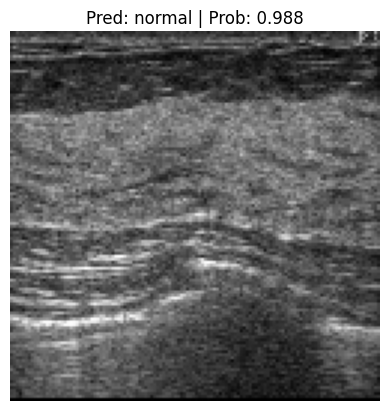

In [55]:
# Make a prediction for a normal image
pred_and_plot_image(model = model_3,
                    image_path = "/content/normal_breast_ultrasound.jpg",
                    class_names = classes,
                    transform = custom_transform,
                    device = device)